# Proyecto 1

En este colab NO se hizo la ejecución completa de la parte de prepocesamiento de la data, este preoprocesamiento se hizo en VSCode con la finalidad de ahorrar tiempo en el entrenamiento de nuestros modelos.

Aun así, se realiza una demotración de como se hizo el preprocesamiento de la señal` body_acc_x` utilizando extrac-features y select_features de la librería tsfresh.

Si desea ahorra tiempo en la ejecución de preprocesamiento de la data, es recomendable saltar los apartados: #### 3.2.1 Procesamiento en COLAB y 4.1.1 Procesamiento en COLAB

En el presene drive se encuentran todas las 9 señales procesadas con la librería tsfrest. Este procesamiento se hizo tanto para train.h5 como para test.h5. https://drive.google.com/drive/folders/1u7Zv7IrcCIMyHB7cU6f45oeO9q5RHPgY?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tsfresh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.9 MB/s eta 0:00:00


Librerías

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler   # Para escalar características (muy recomendable)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# 1. Reconocimiento de la data

### **Data de training**

Se observa que la data de testeo esta compuesta por 9 señales:

*  **Aceleración del cuerpo: ----------------------------------------------**

    `body_acc_x, body_acc_y, body_acc_z`

    Aceleración del movimiento corporal (sin gravedad) en los ejes X, Y y Z.Esto se obtiene tras filtrar la componente gravitacional del total de la aceleración.


*  **Velocidad angular del cuerpo (giroscopio):--------------------------**
    
    `body_gyro_x, body_gyro_y, body_gyro_z`

    Velocidad angular (rotación del cuerpo) medida por el giroscopio en los ejes X, Y y Z.

*  **Aceleración total (incluye gravedad):---------------------------------**

    `total_acc_x, total_acc_y, total_acc_z`

    Aceleración total medida por el acelerómetro, que incluye tanto el movimiento del cuerpo como la fuerza de gravedad.

Además, se observa se tomaron 7352 muestras de cada una de las señales (aceleración del cuerpo, velocidad angular del cuerpo, y aceleración total). Y cada una de esas muestras 128 puntos temporales. Es decir, cada muestra contiene 128 valores consecutivos medidos a lo largo del tiempo.

*Según la información de Kaggle:*

Cada muestra tiene un tamaño de 2.56 segundos con 50 Hz de muestreo (50 datos por segundo), lo que da:


$ 50 Hz × 2.56s = 128 puntos-temporales-por-muestra $

Por otra parte, se puede calcular cada cuanto tiempo se tomo cada punto temporal y este valor es de:

*   $ t = 2.56s / 128 puntos $

*   $ t = 0.02 s $


In [ ]:
with h5py.File('/content/drive/MyDrive/Proyecto1ML/train.h5', 'r') as f:

    claves = list(f.keys())

    senales_train = {} # Diccionario para almacenar cada dataset por separado

    for nombre_grupo in f.keys():
        print(f"{nombre_grupo}, forma: {f[nombre_grupo][:].shape}")

    # Una vez observados los datos, se sabe que la ultima dataset es la variable objetivo
    # Esta considera los siguientes labels:
    # 1 WALKING
    # 2 WALKING_UPSTAIRS
    # 3 WALKING_DOWNSTAIRS
    # 4 SITTING
    # 5 STANDING
    # 6 LAYING

    for clave in claves[:-1]:  # Excluye el último elemento
        datos = f[clave][:]
        senales_train[clave] = datos

    y = f['y'][:]

    etiquetas_train = pd.DataFrame({
        'id': range(len(y)),
        'target': y.flatten()
    })

body_acc_x, forma: (7352, 128)
body_acc_y, forma: (7352, 128)
body_acc_z, forma: (7352, 128)
body_gyro_x, forma: (7352, 128)
body_gyro_y, forma: (7352, 128)
body_gyro_z, forma: (7352, 128)
total_acc_x, forma: (7352, 128)
total_acc_y, forma: (7352, 128)
total_acc_z, forma: (7352, 128)
y, forma: (7352,)


In [ ]:
# Se muestr parcialmente la data de una se la señales [body_acc_x]
body_acc_x = senales_train['body_acc_x']
df_body_acc_x = pd.DataFrame(body_acc_x[:,:])
print(df_body_acc_x.head(4))

        0         1         2         3         4         5         6    \
0  0.000181  0.010139  0.009276  0.005066  0.010810  0.004045  0.004757   
1  0.001094  0.004550  0.002879  0.002247  0.003305  0.002416  0.001619   
2  0.003531  0.002285 -0.000420 -0.003738 -0.006706 -0.003148  0.000733   
3 -0.001772 -0.001311  0.000388  0.000408 -0.000355  0.000998  0.001109   

        7         8         9    ...       118       119       120       121  \
0  0.006214  0.003307  0.007572  ...  0.001412 -0.001509  0.000060  0.000435   
1  0.000981  0.000009 -0.000363  ... -0.000104 -0.000141  0.001333  0.001541   
2  0.000668  0.002162 -0.000946  ...  0.000661  0.001853 -0.000268 -0.000394   
3 -0.003149 -0.008882 -0.010483  ...  0.000458  0.002103  0.001358  0.000820   

        122       123       124       125       126       127  
0 -0.000819  0.000228 -0.000300 -0.001147 -0.000222  0.001576  
1  0.001077 -0.000736 -0.003767 -0.004646 -0.002941 -0.001599  
2 -0.000279 -0.000316  0.000144

In [ ]:
# Se muestran la variable objetivo, el tipo de actividad que esta realizando la persona
# Esta considera los siguientes labels:
  # 1 WALKING
  # 2 WALKING_UPSTAIRS
  # 3 WALKING_DOWNSTAIRS
  # 4 SITTING
  # 5 STANDING
  # 6 LAYING
etiquetas_train

,id,target
0,0,5.0
1,1,5.0
2,2,5.0
3,3,5.0
4,4,5.0
...,...,...
7347,7347,2.0
7348,7348,2.0
7349,7349,2.0
7350,7350,2.0


### **Data de test**

In [ ]:
with h5py.File('/content/drive/MyDrive/Proyecto1ML/test.h5', 'r') as f_test:

    claves_test = list(f_test.keys())
    senales_test = {} # Diccionario para almacenar cada dataset por separado

    for nombre_grupo in f_test.keys():
        print(f"{nombre_grupo}, forma: {f_test[nombre_grupo][:].shape}")
    # En este caso no contamos con variable objetivo, es la data de testeo con la cual se intenta predecir "y"

    for clave in claves_test:
        datos = f_test[clave][:]
        senales_test[clave] = datos

body_acc_x, forma: (2947, 128)
body_acc_y, forma: (2947, 128)
body_acc_z, forma: (2947, 128)
body_gyro_x, forma: (2947, 128)
body_gyro_y, forma: (2947, 128)
body_gyro_z, forma: (2947, 128)
total_acc_x, forma: (2947, 128)
total_acc_y, forma: (2947, 128)
total_acc_z, forma: (2947, 128)


In [ ]:
body_acc_x_tr = senales_test['body_acc_x']
df_body_acc_x_tr = pd.DataFrame(body_acc_x_tr[:,:])
print(df_body_acc_x_tr.head(4))

        0         1         2         3         4         5         6    \
0  0.011653  0.013109  0.011269  0.027831  0.002318 -0.018965 -0.061920   
1  0.009280  0.004930  0.003954  0.009214  0.016156  0.014079  0.013105   
2  0.005732  0.007066  0.005110  0.002434  0.002024  0.001382  0.001930   
3  0.000452  0.000604 -0.002485 -0.004562 -0.006002 -0.006382 -0.005276   

        7         8         9    ...       118       119       120       121  \
0 -0.094248 -0.079534 -0.070084  ... -0.002944 -0.001247  0.002848  0.002355   
1  0.021247  0.026823  0.031054  ... -0.002533  0.000163 -0.001095 -0.004547   
2  0.004875  0.003776  0.002400  ... -0.004972 -0.003586 -0.003860 -0.003560   
3 -0.001489  0.005153  0.004951  ...  0.001249  0.000978  0.002248  0.003530   

        122       123       124       125       126       127  
0  0.002721  0.003255  0.001301  0.001292  0.001470  0.002574  
1 -0.005310 -0.004094  0.002200  0.007788  0.003433 -0.001239  
2 -0.000974  0.001052  0.000778

# 2. Visualización de la data

Para darnos una idea del comportamiento de la data en el tiempo, se eligió calcular el promedio de las señales por tipo de actividad:

In [ ]:
#Selección de los dataframes
body_acc_x = senales_train['body_acc_x']
df_body_acc_x = pd.DataFrame(body_acc_x[:,:])
body_acc_y = senales_train['body_acc_y']
df_body_acc_y = pd.DataFrame(body_acc_y[:,:])
body_acc_z = senales_train['body_acc_z']
df_body_acc_z = pd.DataFrame(body_acc_z[:,:])

body_gyro_x = senales_train['body_gyro_x']
df_body_gyro_x = pd.DataFrame(body_gyro_x[:,:])
body_gyro_y = senales_train['body_gyro_y']
df_body_gyro_y = pd.DataFrame(body_gyro_y[:,:])
body_gyro_z = senales_train['body_gyro_z']
df_body_gyro_z = pd.DataFrame(body_gyro_z[:,:])

total_acc_x = senales_train['total_acc_x']
df_total_acc_x = pd.DataFrame(total_acc_x[:,:])
total_acc_y = senales_train['total_acc_y']
df_total_acc_y = pd.DataFrame(total_acc_y[:,:])
total_acc_z = senales_train['total_acc_z']
df_total_acc_z = pd.DataFrame(total_acc_z[:,:])

Se creo una función que permite hacer gráficas de cada una de las señales:
*  `(body_acc_x, body_acc_y, body_acc_z, body_gyro_x, body_gyro_y, body_gyro_z, total_acc_x, total_acc_y, total_acc_z)`, sacando un promedio de todas las 7352 muestras en cada uno de los tiempos (de 0 a 127) y fueron clasificadas por tipo de actividad.

In [ ]:
def graficar_senal_por_actividad(df_senal, etiquetas_df, nombre_senal='Señal'):
    """
    Grafica la señal promedio por tipo de actividad.

    Parámetros:
    - df_senal: DataFrame (n_muestras, 128) con datos de la señal (por ejemplo, df_body_acc_x)
    - etiquetas_df: DataFrame con columnas 'id' y 'target'
    - nombre_senal: Nombre de la señal para el título del gráfico
    """
    actividades = {
        1: 'Caminar',
        2: 'Subir escaleras',
        3: 'Bajar escaleras',
        4: 'Sentado',
        5: 'De pie',
        6: 'Acostado'
    }

    tiempo = np.arange(128) * 0.02  # Convertimos a segundos

    plt.figure(figsize=(10, 6))

    for actividad_id, nombre in actividades.items():
        # Obtener índices donde la actividad coincide
        indices = etiquetas_df[etiquetas_df['target'] == actividad_id].index
        señales_actividad = df_senal.iloc[indices]

        media = señales_actividad.mean(axis=0)

        plt.plot(tiempo, media, label=nombre)

    plt.title(f'{nombre_senal} - media por Actividad')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Valor de la señal')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

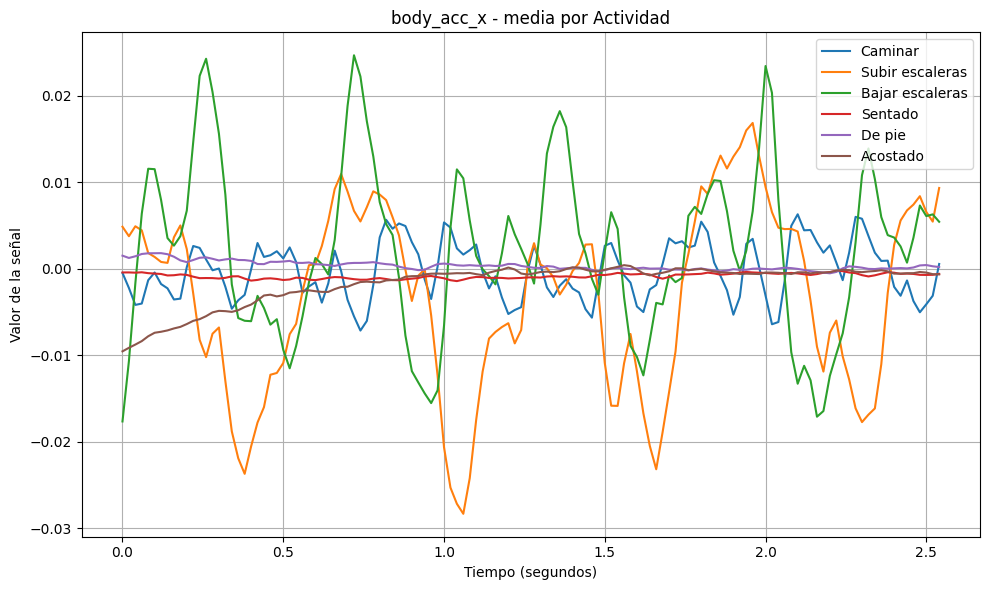

In [ ]:
graficar_senal_por_actividad(df_body_acc_x, etiquetas_train, nombre_senal='body_acc_x')

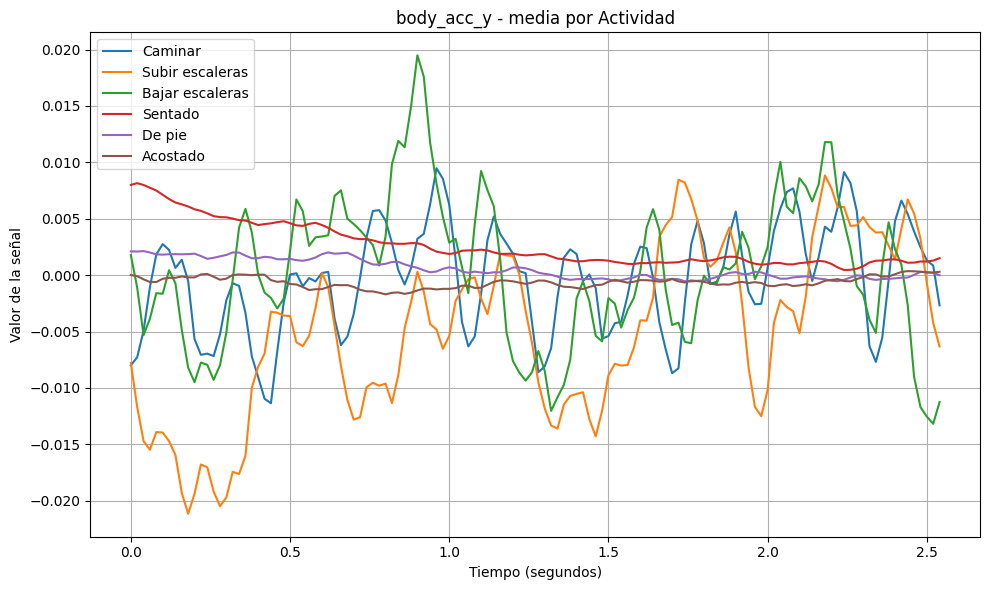

In [ ]:
graficar_senal_por_actividad(df_body_acc_y, etiquetas_train, nombre_senal='body_acc_y')

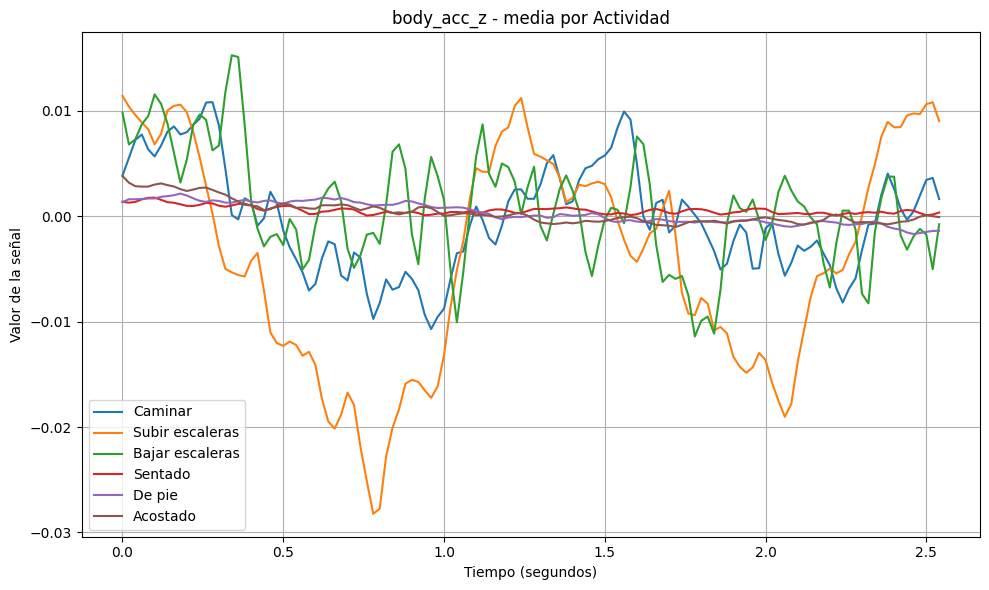

In [ ]:
graficar_senal_por_actividad(df_body_acc_z, etiquetas_train, nombre_senal='body_acc_z')

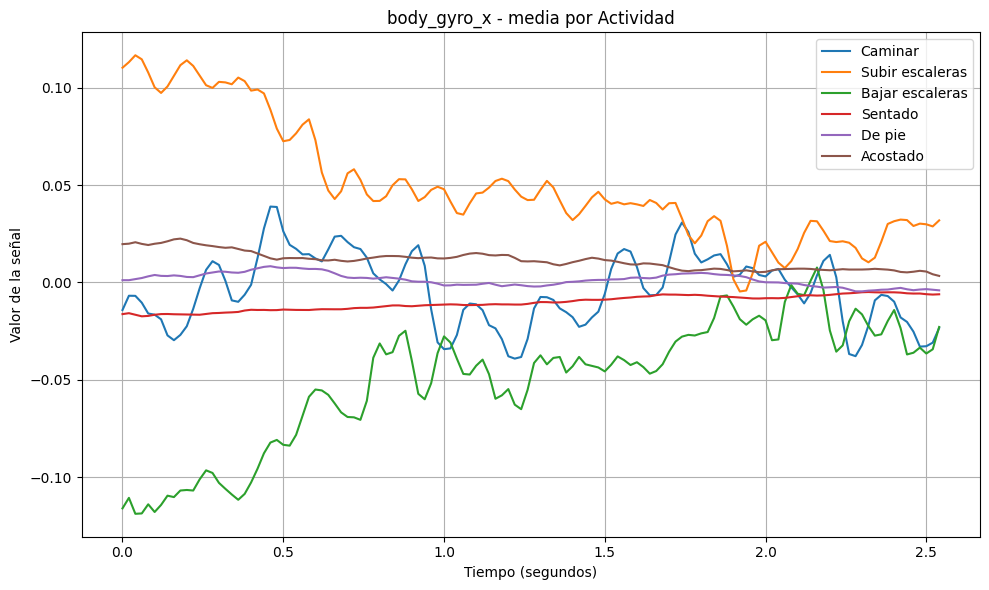

In [ ]:
graficar_senal_por_actividad(df_body_gyro_x, etiquetas_train, nombre_senal='body_gyro_x')

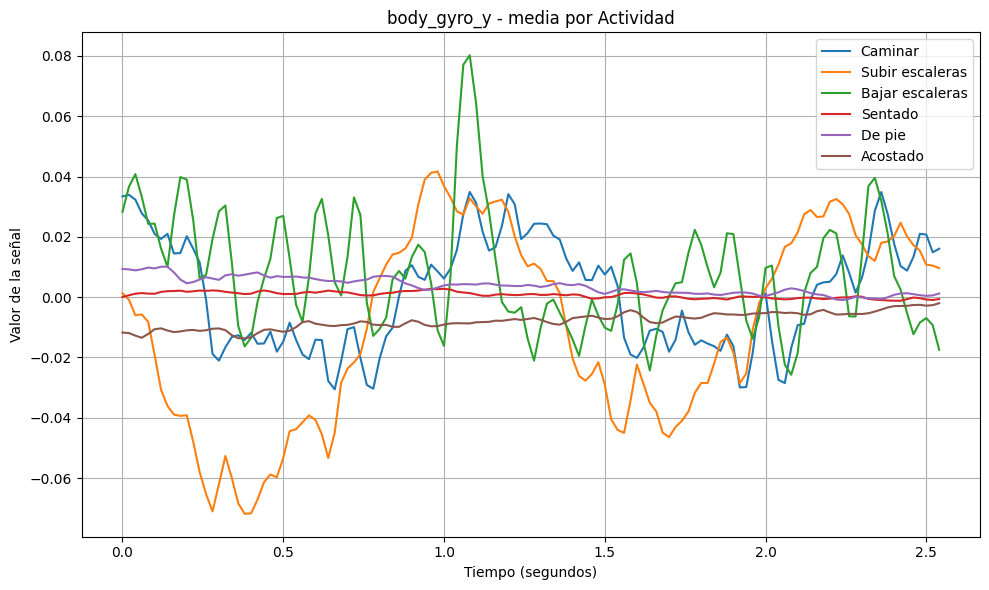

In [ ]:
graficar_senal_por_actividad(df_body_gyro_y, etiquetas_train, nombre_senal='body_gyro_y')

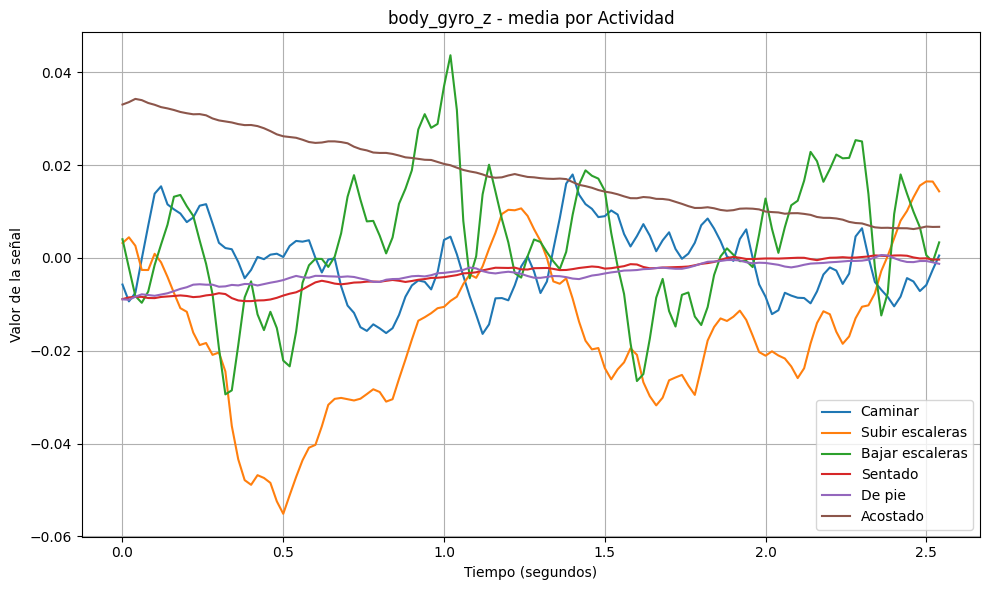

In [ ]:
graficar_senal_por_actividad(df_body_gyro_z, etiquetas_train, nombre_senal='body_gyro_z')

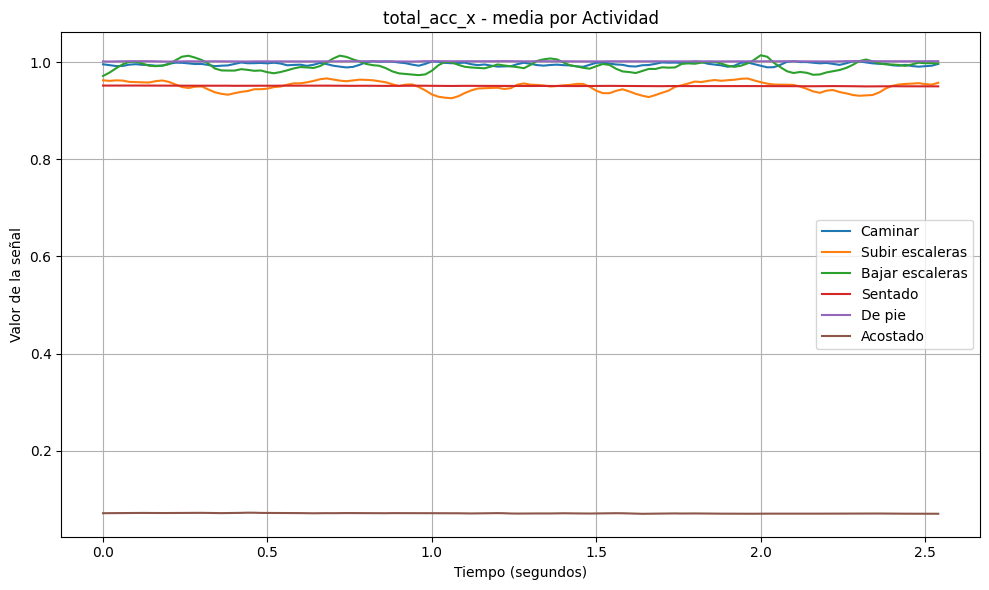

In [ ]:
graficar_senal_por_actividad(df_total_acc_x, etiquetas_train, nombre_senal='total_acc_x')

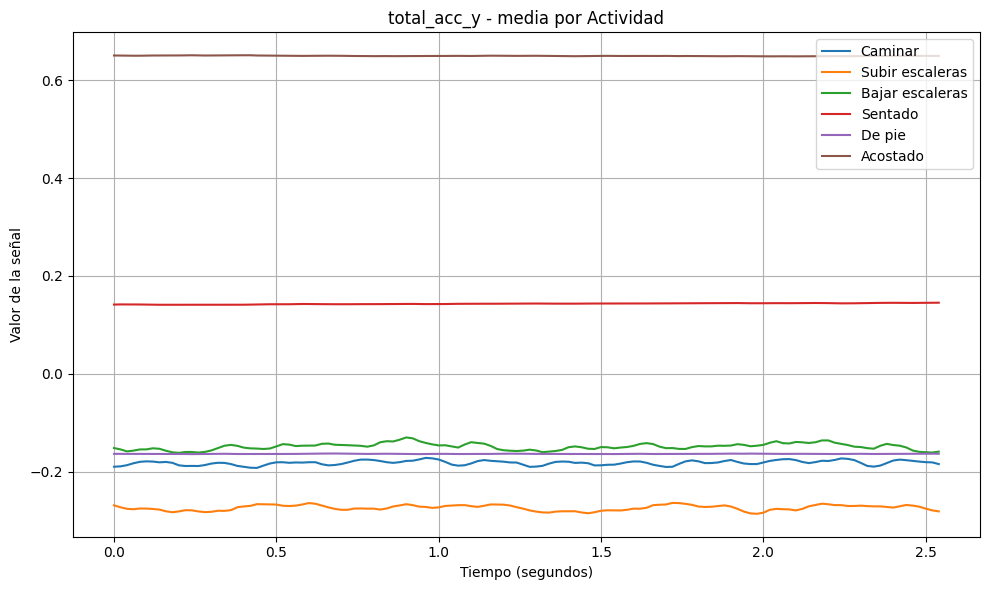

In [ ]:
graficar_senal_por_actividad(df_total_acc_y, etiquetas_train, nombre_senal='total_acc_y')

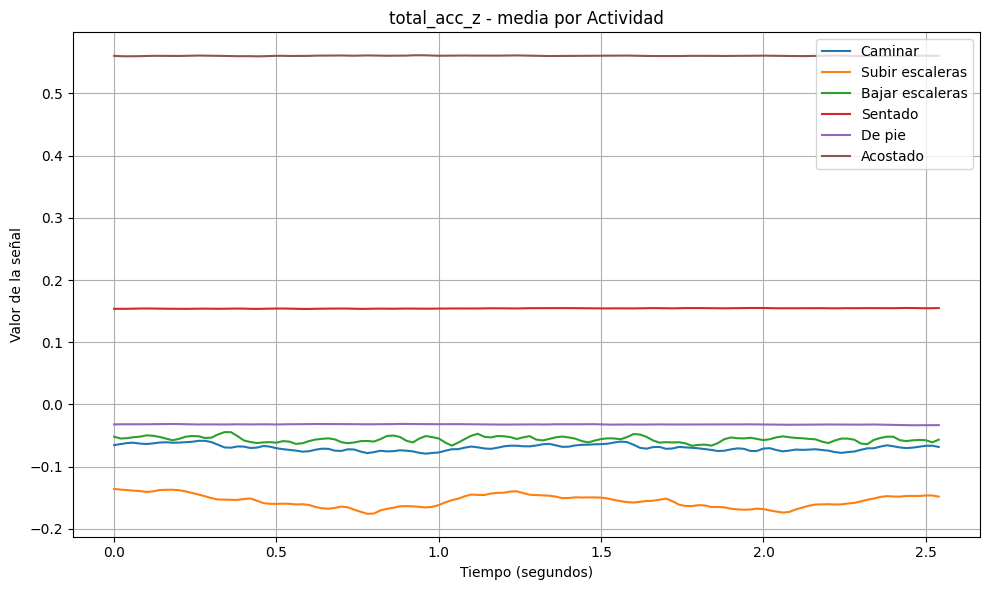

In [ ]:
graficar_senal_por_actividad(df_total_acc_z, etiquetas_train, nombre_senal='total_acc_z')

# 3. Procesamiento de la data extraida de *train.h5* para su entrenamiento

### 3.1 Pasear la data

La `función parsear_senal(dF)` convierte un DataFrame de forma (n_muestras, 128) en un formato largo:
* id: número de muestra
* time: valor de la serie de tiempo
* valor: valor de la señal
Asume que cada fila es una muestra temporal.

Se hace esto para que se pueda hacer el procesamiento de las series de tiempo con la librería `tsfresh`

In [ ]:
# Función para parsear una sola señal
def parsear_senal(df):
    parsed = []
    for idx, row in df.iterrows():
        df_temp = pd.DataFrame({
            'id': idx,
            'time': np.arange(len(row)) * 0.02,  # Tiempo en segundos
            'valor': row.values
        })
        parsed.append(df_temp)
    return pd.concat(parsed, ignore_index=True)

In [ ]:
# se hace la prueba para las primeras, señales:
df_parseado_body_acc_x = parsear_senal(df_body_acc_x)
print(df_parseado_body_acc_x.head(10))
# El tamaño del dataframe se entiende de la siguiente forma:
  # numero de columnas => 3
  # numero de filas => 128 valores de tiempo * 7352 muestras = 941056
print(df_parseado_body_acc_x.shape)

   id  time     valor
0   0  0.00  0.000181
1   0  0.02  0.010139
2   0  0.04  0.009276
3   0  0.06  0.005066
4   0  0.08  0.010810
5   0  0.10  0.004045
6   0  0.12  0.004757
7   0  0.14  0.006214
8   0  0.16  0.003307
9   0  0.18  0.007572
(941056, 3)


In [ ]:
df_parseado_body_acc_y = parsear_senal(df_body_acc_y)
print(df_parseado_body_acc_y.head(10))

   id  time     valor
0   0  0.00  0.010767
1   0  0.02  0.006579
2   0  0.04  0.008929
3   0  0.06  0.007489
4   0  0.08  0.006141
5   0  0.10  0.006944
6   0  0.12  0.003552
7   0  0.14  0.002537
8   0  0.16  0.004085
9   0  0.18  0.005118


###3.2. Usar *extract_features* y *select_features* de *tsfresh*

 Con `extract_features`, se extraen las características relevantes de las señales. Esto se hace para cada señal y se genera un `DataFrame_X` donde cada fila representa una muestra ("ventana") de la señal y las columnas son las características extraídas (como media, varianza, etc.). Es decir, para el entrenamiento ya no se trabaja con series de tiempo, sino con las características representativas de esas series.

Luego, la función `select_features` selecciona las características más relevantes respecto a la variable objetivo y. Si una característica tiene poca relación con y, se elimina.

*  Internamente, select_features utiliza un algoritmo basado en pruebas estadísticas (como la correlación de Pearson o la selección basada en información mutua) para determinar la relevancia de cada característica.

*  La selección de características ayuda a reducir el modelo, eliminando las variables que no tienen impacto significativo en la variable dependiente.


####3.2.1 Porcesamiento en COLAB

In [ ]:
def procesar_senal(nombre_senal, parsed_df, etiquetas):
    print(f"Procesando {nombre_senal}...")   # Mostrar el nombre de la señal que se está procesando

    # Paso 1: Extraer características estadísticas a partir de la señal ya parseada
    # Se espera que parsed_df tenga columnas 'id' (para cada muestra) y 'time' (orden temporal)
    X = extract_features(parsed_df, column_id='id', column_sort='time')

    # Paso 2: Eliminar columnas con varianza cero (es decir, que no aportan información)
    selector = VarianceThreshold(threshold=0.0)               # Umbral 0.0 → elimina columnas constantes
    X_transformed = selector.fit_transform(X)                 # Aplicar el filtro
    columnas_filtradas = X.columns[selector.get_support()]   # Obtener nombres de columnas que se mantienen
    X = pd.DataFrame(X_transformed, columns=columnas_filtradas, index=X.index)  # Reconstruir el DataFrame
    X['id'] = X.index                                         # Restaurar la columna 'id'

    # Paso 3: Imputar valores faltantes (NaN) para evitar errores en los pasos siguientes
    X = X.fillna(0)                                           # Reemplazar NaNs con 0 (puedes ajustar esta estrategia)

    # Paso 4: Seleccionar solo las características más relevantes respecto al target
    # Usa la columna 'target' de las etiquetas como variable objetivo
    X_selected = select_features(X.drop(columns='id'), etiquetas['target'])

    # Restaurar la columna 'id' después de la selección
    X_selected['id'] = X['id'].values

    # Paso 5: Añadir prefijo a los nombres de las columnas para evitar colisiones al juntar múltiples señales
    X_selected = X_selected.add_prefix(f"{nombre_senal}__")  # Prefijo con el nombre de la señal
    X_selected.rename(columns={f"{nombre_senal}__id": "id"}, inplace=True)  # Renombrar la columna id

    return X, X_selected

In [ ]:
df_sin_proces_body_acc_x, df_procesado_body_acc_x = procesar_senal("body_acc_x", df_parseado_body_acc_x, etiquetas_train)

Procesando body_acc_x...


Feature Extraction: 100%|██████████| 7352/7352 [16:57<00:00,  7.22it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:122: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


In [ ]:
print(df_sin_proces_body_acc_x.head(4))

   valor__has_duplicate  valor__sum_values  valor__abs_energy  \
0                   0.0           0.290392           0.001766   
1                   0.0           0.022239           0.000506   
2                   0.0           0.054796           0.001106   
3                   0.0           0.042157           0.000932   

   valor__mean_abs_change  valor__mean_change  \
0                0.001435            0.000011   
1                0.001323           -0.000021   
2                0.001827           -0.000011   
3                0.001470            0.000014   

   valor__mean_second_derivative_central  valor__median  valor__mean  \
0                              -0.000032       0.002025     0.002269   
1                              -0.000008       0.000110     0.000174   
2                               0.000001       0.000627     0.000428   
3                               0.000003       0.000269     0.000329   

   valor__standard_deviation  valor__variation_coefficient  ...  \


In [ ]:
print(df_procesado_body_acc_x.head(4))

   body_acc_x__valor__fft_coefficient__attr_"abs"__coeff_46  \
0                                           0.017670          
1                                           0.012607          
2                                           0.004044          
3                                           0.009752          

   body_acc_x__valor__ar_coefficient__coeff_7__k_10  \
0                                          1.026931   
1                                          1.619223   
2                                          1.800287   
3                                          1.810779   

   body_acc_x__valor__ar_coefficient__coeff_6__k_10  \
0                                         -1.110093   
1                                         -1.978130   
2                                         -2.170074   
3                                         -2.171590   

   body_acc_x__valor__ar_coefficient__coeff_5__k_10  \
0                                          1.300560   
1                     

Se observa que el procesamiento para la señal `body_acc_y` se paso de **602 características** a **333 características** importantes obtenidas con `select_features`. Debido al considerable tiempo que puede tomar ejecutar el procesamiento de cada una de las señales, este proceso se realizo de forma externa en VStudioCode y las dataframes procesadas para cada una de las señales (grupo training), fueron subidas al google drive compartido al inicio de este documento en la carpeta "trainfilt".

3.2.2 Porcesamiento en fuera de COLAB (VSCodes)

In [ ]:
df_body_acc_x_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/body_acc_x_trainfil.csv")
df_body_acc_y_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/body_acc_y_trainfil.csv")
df_body_acc_z_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/body_acc_z_trainfil.csv")

df_body_gyro_x_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/body_gyro_x_trainfil.csv")
df_body_gyro_y_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/body_gyro_y_trainfil.csv")
df_body_gyro_z_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/body_gyro_z_trainfil.csv")

df_total_acc_x_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/total_acc_x_trainfil.csv")
df_total_acc_y_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/total_acc_y_trainfil.csv")
df_total_acc_z_trainfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/trainfilt/total_acc_z_trainfil.csv")

In [ ]:
print(df_body_acc_x_trainfil.shape)
print(df_body_acc_y_trainfil.shape)
print(df_body_acc_z_trainfil.shape)
print(df_body_gyro_x_trainfil.shape)
print(df_body_gyro_y_trainfil.shape)
print(df_body_gyro_z_trainfil.shape)
print(df_total_acc_x_trainfil.shape)
print(df_total_acc_y_trainfil.shape)
print(df_total_acc_z_trainfil.shape)

(7352, 333)
(7352, 339)
(7352, 299)
(7352, 339)
(7352, 324)
(7352, 407)
(7352, 384)
(7352, 376)
(7352, 371)


In [ ]:
# Se muestran los primeros valores del primer dataFrame, y como la ultima columana corresponde al indice
df_body_acc_x_trainfil.head(3)

,"body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","body_acc_x__valor__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",...,"body_acc_x__valor__fft_coefficient__attr_""angle""__coeff_57","body_acc_x__valor__fft_coefficient__attr_""angle""__coeff_54",body_acc_x__valor__ratio_beyond_r_sigma__r_6,"body_acc_x__valor__fft_coefficient__attr_""imag""__coeff_22","body_acc_x__valor__fft_coefficient__attr_""angle""__coeff_56","body_acc_x__valor__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","body_acc_x__valor__fft_coefficient__attr_""angle""__coeff_58",body_acc_x__valor__energy_ratio_by_chunks__num_segments_10__segment_focus_2,body_acc_x__valor__lempel_ziv_complexity__bins_2,id
0,1.639810e-07,0.001101,6.368649e-07,0.000005,0.001517,2.344345e-06,1.318629e-06,0.000936,4.520684e-07,2.109719e-06,...,111.350023,92.616719,0.0,-0.000445,106.226952,0.007428,116.565535,0.139401,0.210938,0
1,1.241462e-07,0.000652,2.440310e-07,0.000002,0.001062,7.948448e-07,5.368966e-08,0.000198,3.533359e-08,3.412811e-07,...,-164.862158,174.274143,0.0,-0.006919,-162.970088,0.004857,-165.542588,0.157085,0.226562,1
2,8.246671e-09,0.001114,7.243013e-07,0.000003,0.001412,1.176097e-06,3.731268e-08,0.000144,2.031322e-08,9.836059e-07,...,-30.067904,-16.975970,0.0,0.018214,-36.647181,-0.004036,-25.524406,0.051568,0.210938,2


Luego, concatenamos todos los dataframes en uno solo

In [ ]:
df_final_train = pd.concat([df_body_acc_x_trainfil.iloc[:, :-1],
                      df_body_acc_y_trainfil.iloc[:, :-1],
                      df_body_acc_z_trainfil.iloc[:, :-1],
                      df_body_gyro_x_trainfil.iloc[:, :-1],
                      df_body_gyro_y_trainfil.iloc[:, :-1],
                      df_body_gyro_z_trainfil.iloc[:, :-1],
                      df_total_acc_x_trainfil.iloc[:, :-1],
                      df_total_acc_y_trainfil.iloc[:, :-1],
                      df_total_acc_z_trainfil.iloc[:, :-1]], axis=1)
df_final_train.shape

(7352, 3163)

In [ ]:
#Eliminamos la columna indice y nos quedamos con los targets
etiquetas_train=etiquetas_train.iloc[:, -1:]
print(etiquetas_train.shape)

(7352, 1)


# 4. Procesamiento de la data extraida de *test.h5* para el testeo

Se procede a hacer el mismo procesamiento de data, con la data de testeo

In [ ]:
body_acc_x_tr = senales_test['body_acc_x']
df_body_acc_x_tr = pd.DataFrame(body_acc_x_tr[:,:])
body_acc_y_tr = senales_test['body_acc_y']
df_body_acc_y_tr = pd.DataFrame(body_acc_y_tr[:,:])
body_acc_z_tr = senales_train['body_acc_z']
df_body_acc_z_tr = pd.DataFrame(body_acc_z_tr[:,:])

body_gyro_x_tr = senales_test['body_gyro_x']
df_body_gyro_x_tr = pd.DataFrame(body_gyro_x_tr[:,:])
body_gyro_y_tr = senales_test['body_gyro_y']
df_body_gyro_y_tr = pd.DataFrame(body_gyro_y_tr[:,:])
body_gyro_z_tr = senales_test['body_gyro_z']
df_body_gyro_z_tr = pd.DataFrame(body_gyro_z_tr[:,:])

total_acc_x_tr = senales_test['total_acc_x']
df_total_acc_x_tr = pd.DataFrame(total_acc_x_tr[:,:])
total_acc_y_tr = senales_test['total_acc_y']
df_total_acc_y_tr = pd.DataFrame(total_acc_y_tr[:,:])
total_acc_z_tr = senales_test['total_acc_z']
df_total_acc_z_tr = pd.DataFrame(total_acc_z_tr[:,:])

Ahora el número de filas se ha reducido, y esto es por que el número de muestras es 2947.


Luego se tiene:

$ 2947 muestras × 128 valores-de-tiempo  = 377216 filas $


In [ ]:
# se hace la prueba para las primeras, señales:
df_parseado_body_acc_x_tr = parsear_senal(df_body_acc_x_tr)
print(df_parseado_body_acc_x_tr.head(10))
# El tamaño del dataframe se entiende de la siguiente forma:
  # numero de columnas => 3
  # numero de filas => 128 valores de tiempo * 7352 muestras = 941056
print(df_parseado_body_acc_x_tr.shape)

   id  time     valor
0   0  0.00  0.011653
1   0  0.02  0.013109
2   0  0.04  0.011269
3   0  0.06  0.027831
4   0  0.08  0.002318
5   0  0.10 -0.018965
6   0  0.12 -0.061920
7   0  0.14 -0.094248
8   0  0.16 -0.079534
9   0  0.18 -0.070084
(377216, 3)


#### 4.1.1 Porcesamiento en COLAB

In [ ]:
def procesar_senal_train(nombre_senal, parsed_df):
    print(f"Procesando {nombre_senal}...")

    # Paso 1: Extraer características estadísticas a partir de la señal ya parseada
    X = extract_features(parsed_df, column_id='id', column_sort='time')

    # Paso 2: Imputar valores faltantes (NaN) para evitar errores en los pasos siguientes
    X = X.fillna(0)

    # Paso 5: Añadir prefijo a los nombres de las columnas para evitar colisiones al juntar múltiples señales
    X = X.add_prefix(f"{nombre_senal}__")  # Prefijo con el nombre de la señal
    X.rename(columns={f"{nombre_senal}__id": "id"}, inplace=True)  # Renombrar la columna id

    return X

In [ ]:
df_procesado_body_acc_x_train = procesar_senal_train("body_acc_x", df_parseado_body_acc_x_tr)

Procesando body_acc_x...


Feature Extraction: 100%|██████████| 2947/2947 [06:47<00:00,  7.24it/s]


In [ ]:
print(df_procesado_body_acc_x_train.head(4))

   body_acc_x__valor__variance_larger_than_standard_deviation  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            

   body_acc_x__valor__has_duplicate_max  body_acc_x__valor__has_duplicate_min  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   

   body_acc_x__valor__has_duplicate  body_acc_x__valor__sum_values  \
0                               0.0                      -0.538065   
1                               0.0                       0.222922   
2                               0.0                      -

#### 4.1.2 Porcesamiento en fuera de COLAB (VSCode)

Se observa que la data de entrenamiento tiene aun más columnas de características, y esto es debido a que no se pudo aplicar la `select_features` de `tsfresh`, debido a que en el caso de la da de testing no contamos con los `targets`.

Del mismo modos, debido al considerable tiempo que puede tomar ejecutar el procesamiento de cada una de las señales, este proceso se realizo de forma externa en VStudioCode y las dataframes procesadas para cada una de las señales (grupo testing), fueron subidas al google drive compartido al inicio de este documento en la carpeta "testfilt".

In [ ]:
df_body_acc_x_testfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/body_acc_x_testfilt.csv")
df_body_acc_y_testfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/body_acc_y_testfilt.csv")
df_body_acc_z_testfil = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/body_acc_z_testfilt.csv")

df_body_gyro_x_testfilt = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/body_gyro_x_testfilt.csv")
df_body_gyro_y_testfilt = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/body_gyro_y_testfilt.csv")
df_body_gyro_z_testfilt = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/body_gyro_z_testfilt.csv")

df_total_acc_x_testfilt = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/total_acc_x_testfilt.csv")
df_total_acc_y_testfilt = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/total_acc_y_testfilt.csv")
df_total_acc_z_testfilt = pd.read_csv("/content/drive/MyDrive/Proyecto1ML/testfilt/total_acc_z_testfilt.csv")


In [ ]:
print(df_body_acc_x_testfil.shape)
print(df_body_acc_y_testfil.shape)
print(df_body_acc_z_testfil.shape)
print(df_body_gyro_x_testfilt.shape)
print(df_body_gyro_y_testfilt.shape)
print(df_body_gyro_z_testfilt.shape)
print(df_total_acc_x_testfilt.shape)
print(df_total_acc_y_testfilt.shape)
print(df_total_acc_z_testfilt.shape)

(2947, 783)
(2947, 783)
(2947, 783)
(2947, 783)
(2947, 783)
(2947, 783)
(2947, 783)
(2947, 783)
(2947, 783)


Tiene sentido que todos los dataframes tengan el mismo tamaño, dado que a ninguno de ellos se le ha seleccionado las caracteristicas importantes

In [ ]:
df_final_test_sin_filtro = pd.concat([df_body_acc_x_testfil,
                            df_body_acc_y_testfil,
                            df_body_acc_z_testfil,
                            df_body_gyro_x_testfilt,
                            df_body_gyro_y_testfilt,
                            df_body_gyro_z_testfilt,
                            df_total_acc_x_testfilt,
                            df_total_acc_y_testfilt,
                            df_total_acc_z_testfilt
                            ], axis=1)
df_final_test_sin_filtro.shape

(2947, 7047)

In [ ]:
# Obtener nombres de columnas como lista
columnas_comunes = df_final_train.columns
print(columnas_comunes.shape)
print(columnas_comunes)

(3163,)
Index(['body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'body_acc_x__valor__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
       'body_acc_x__valor__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
       'body_acc_x__valor__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       'body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4',
       'body_acc_x__valor__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       ...
       'total_acc_z__valor__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)',
       'total_acc_z_

In [ ]:
# Usar esas columnas para filtrar las columnas presentes en df_clean_test
df_final_test = df_final_test_sin_filtro[columnas_comunes.intersection(df_final_test_sin_filtro.columns)]
print(df_final_test.shape)
X_test = df_final_test
X_test.head()

(2947, 3163)


,"body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","body_acc_x__valor__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","body_acc_x__valor__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",...,"total_acc_z__valor__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","total_acc_z__valor__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","total_acc_z__valor__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","total_acc_z__valor__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","total_acc_z__valor__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""",total_acc_z__valor__index_mass_quantile__q_0.9,"total_acc_z__valor__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)","total_acc_z__valor__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","total_acc_z__valor__fft_coefficient__attr_""imag""__coeff_12",total_acc_z__valor__large_standard_deviation__r_0.30000000000000004
0,4.372307e-05,0.004121,1.446201e-05,0.000089,0.006437,0.000048,2.533494e-06,0.001358,1.746737e-06,7.506383e-06,...,0.019621,-0.059659,-0.002234,0.725867,0.064712,0.914062,0.024525,0.601604,0.025526,0.0
1,7.770322e-07,0.001390,1.301849e-06,0.000008,0.002089,0.000004,2.778257e-07,0.000454,1.309310e-07,2.099915e-06,...,-0.005802,-0.065321,-0.047912,-0.367159,-0.997160,0.898438,0.027608,-0.400261,0.075480,0.0
2,4.703542e-06,0.001385,1.275359e-06,0.000005,0.001796,0.000002,1.751346e-07,0.000322,7.528685e-08,6.924231e-07,...,0.004956,0.017572,0.018909,0.199897,-0.284701,0.898438,0.005393,0.219305,-0.074643,0.0
3,3.526725e-07,0.001592,1.231502e-06,0.000006,0.001938,0.000002,4.767252e-07,0.000647,7.129498e-08,1.439800e-06,...,-0.005959,-0.005879,-0.010036,-0.270771,-0.872769,0.898438,0.020104,-0.327660,-0.236863,0.0
4,1.376544e-06,0.001479,9.048678e-07,0.000005,0.001836,0.000002,4.407277e-07,0.000537,1.806154e-07,2.304587e-06,...,-0.005298,0.017630,0.010864,-0.547808,-0.968808,0.906250,0.011833,-0.606001,-0.134359,0.0


# 5. Entrenamiento de la data

Se divide la data en conjunto de entrenamiento y conjunto de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_final_train.values, etiquetas_train.values.ravel(), test_size=0.2, random_state=42, stratify=etiquetas_train.values.ravel())
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:",len(X_val))

Tamaño del conjunto de entrenamiento: 5881
Tamaño del conjunto de validación: 1471


Luego se decidieron implementar dos modelos para la data, usando KNN y SVM para data multiclase.

KNN

In [ ]:
from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

class CustomKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        # Calcula distancias Euclidianas entre cada muestra de prueba y todo el entrenamiento
        distances = cdist(X, self.X_train, metric='euclidean')  # shape (n_test, n_train)
        neighbors_idx = np.argsort(distances, axis=1)[:, :self.k]  # índices de los k más cercanos
        predictions = []

        for indices in neighbors_idx:
            k_labels = self.y_train[indices]
            most_common = Counter(k_labels).most_common(1)[0][0]
            predictions.append(most_common)

        return np.array(predictions)

In [ ]:
scaler_knn = MinMaxScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)
X_val_scaled = scaler_knn.transform(X_val)
X_test_scaled = scaler_knn.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
# Evaluación para múltiples valores de k
valores_k = [1, 3, 5, 7, 9]
mejor_k = None
mejor_acc = 0
resultados = []


for k in valores_k:
    modelo = CustomKNN(k=k)
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')

    resultados.append([k, acc, f1, precision, recall])

    if acc > mejor_acc:
        mejor_acc = acc
        mejor_k = k

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados, columns=["K", "Accuracy", "F1 Score", "Precision", "Recall"])

print(df_resultados.to_string(index=False))

print(f"\n✅ Mejor valor de K: {mejor_k} con Accuracy: {round(mejor_acc, 4)}")


 K  Accuracy  F1 Score  Precision   Recall
 1  0.944935  0.944945   0.945230 0.944935
 3  0.956492  0.956408   0.957318 0.956492
 5  0.953773  0.953629   0.954444 0.953773
 7  0.955812  0.955579   0.957166 0.955812
 9  0.956492  0.956261   0.957731 0.956492

✅ Mejor valor de K: 3 con Accuracy: 0.9565


A partir del analisis se seleccionó el mejor modelo con k=3 para hacer las predicciones de la variable target de la data de testeo.

In [ ]:
modelo_final = CustomKNN(k=3)
modelo_final.fit(X_train_scaled, y_train)

<Figure size 800x600 with 0 Axes>

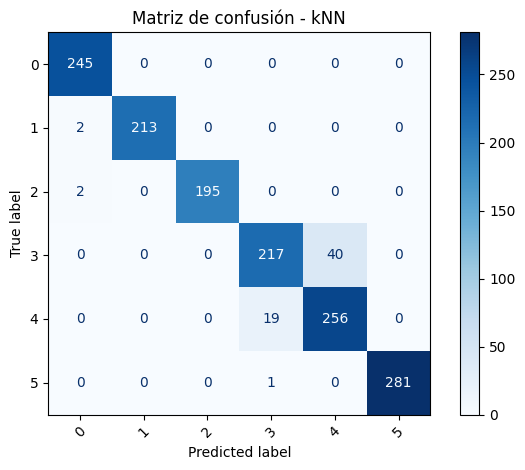

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def mostrar_matriz_confusion(modelo, X_val, y_val, clases=None):
    """
    Muestra la matriz de confusión para el modelo SVM1.

    Parámetros:
    - modelo: el modelo entrenado (en este caso, modelo_SVM1)
    - X_val: conjunto de validación ya escalado
    - y_val: etiquetas reales del conjunto de validación
    - clases: lista opcional de nombres de clases
    """
    y_pred = modelo.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
    plt.title("Matriz de confusión - kNN")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Usar la función
mostrar_matriz_confusion(modelo_final, X_val_scaled, y_val)

In [ ]:
# Realizar las predicciones
predicciones_test = modelo_final.predict(X_test_scaled)

In [ ]:

y_pred_test_knn = predicciones_test

# Diccionario de clases
actividades = {
    1: "Caminando",
    2: "Subiendo escaleras",
    3: "Bajando escaleras",
    4: "Sentado",
    5: "De pie",
    6: "Acostado"
}

# Suponiendo que tu array se llama y_pred
valores1, cantidades1 = np.unique(y_pred_test_knn, return_counts=True)

# Crear DataFrame para mostrar los resultados
resumen1 = pd.DataFrame({
    "Actividad": [actividades[v] for v in valores1],
    "Muestras": cantidades1
})

print(resumen1)

            Actividad  Muestras
0           Caminando       604
1  Subiendo escaleras       455
2   Bajando escaleras       330
3             Sentado       410
4              De pie       613
5            Acostado       535


SVM_Multiclase

In [ ]:
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train)
X_val_scaled2 = scaler.transform(X_val)
X_test_scaled2 = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
import numpy as np

class MultiClassLinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.models = {}  # Diccionario para guardar los clasificadores binarios
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        for cls in self.classes:
            # Convertimos el problema a binario: 1 para la clase actual, -1 para el resto
            y_binary = np.where(y == cls, 1, -1)

            # Inicialización de pesos y bias
            W = np.zeros(n_features)
            b = 0

            # Descenso por gradiente durante n_iters
            for _ in range(self.n_iters):
                margin = y_binary * (np.dot(X, W) + b)
                misclassified = margin < 1

                # Gradientes
                grad_W = self.lambda_param * W - np.dot(X[misclassified].T, y_binary[misclassified]) / n_samples
                grad_b = -np.sum(y_binary[misclassified]) / n_samples

                # Actualización
                W -= self.lr * grad_W
                b -= self.lr * grad_b

            # Guardar el modelo entrenado
            self.models[cls] = {"W": W, "b": b}

    def predict(self, X):
        # Evaluar todos los modelos para cada muestra
        scores = np.zeros((X.shape[0], len(self.classes)))

        for idx, cls in enumerate(self.classes):
            W = self.models[cls]["W"]
            b = self.models[cls]["b"]
            scores[:, idx] = np.dot(X, W) + b

        # Tomar la clase con el mayor score (más lejos del margen)
        return self.classes[np.argmax(scores, axis=1)]

Se probarons con varios hiperparametros para ver cual se ajusta mejor a la data. En base a ello, se generaron 3 modelos

In [ ]:
# Instanciar el modelo

modelo_SVM1 = MultiClassLinearSVM(learning_rate=0.2, lambda_param=0.01, n_iters=1000)
modelo_SVM2 = MultiClassLinearSVM(learning_rate=0.2, lambda_param=0.02, n_iters=2000)
modelo_SVM3 = MultiClassLinearSVM(learning_rate=0.2, lambda_param=0.025, n_iters=3500)
modelo_SVM4 = MultiClassLinearSVM(learning_rate=0.01, lambda_param=0.01, n_iters=1500)

# Entrenar el modelo con el conjunto de entrenamiento
modelo_SVM1.fit(X_train_scaled2, y_train)
modelo_SVM2.fit(X_train_scaled2, y_train)
modelo_SVM3.fit(X_train_scaled2, y_train)
modelo_SVM4.fit(X_train_scaled2, y_train)

In [ ]:
# 5. Hacer predicciones
y_pred_SVM1 = modelo_SVM1.predict(X_val_scaled2)
y_pred_SVM2 = modelo_SVM2.predict(X_val_scaled2)
y_pred_SVM3 = modelo_SVM3.predict(X_val_scaled2)
y_pred_SVM4 = modelo_SVM4.predict(X_val_scaled2)

In [ ]:
# Lista de tuplas: (nombre, modelo, hiperparámetros en texto)
modelos = [
    ("SVM1", modelo_SVM1, "lr=0.2, λ=0.01, iter=1000'"),
    ("SVM2", modelo_SVM2, "lr=0.2, λ=0.02, iter=2000"),
    ("SVM3", modelo_SVM3, "lr=0.2, λ=0.025, iter=3500"),
    ("SVM4", modelo_SVM4, "lr=0.01, λ=0.01, iter=1500")
]

# Lista para guardar los resultados
resultados = []

# Loop sobre cada modelo
for nombre, modelo, hiperparams in modelos:
    y_pred = modelo.predict(X_val_scaled2)

    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    accuracy = accuracy_score(y_val, y_pred)

    resultados.append([nombre, hiperparams, precision, recall, f1, accuracy])

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "-----Hiperparámetros------", "Precisión", "Recall", "F1 Score", "Accuracy"])

# Mostrar como tabla
print(df_resultados)

  Modelo  -----Hiperparámetros------  Precisión    Recall  F1 Score  Accuracy
0   SVM1  lr=0.2, λ=0.01, iter=1000'   0.978961  0.978926  0.978912  0.978926
1   SVM2   lr=0.2, λ=0.02, iter=2000   0.946838  0.936098  0.933185  0.936098
2   SVM3  lr=0.2, λ=0.025, iter=3500   0.959935  0.955133  0.954959  0.955133


<Figure size 800x600 with 0 Axes>

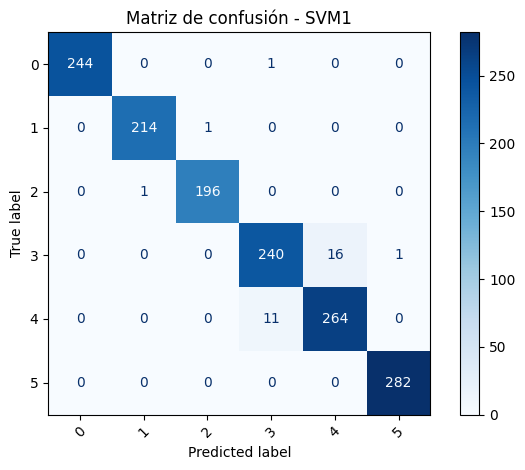

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def mostrar_matriz_confusion(modelo, X_val, y_val, clases=None):
    """
    Muestra la matriz de confusión para el modelo SVM1.

    Parámetros:
    - modelo: el modelo entrenado (en este caso, modelo_SVM1)
    - X_val: conjunto de validación ya escalado
    - y_val: etiquetas reales del conjunto de validación
    - clases: lista opcional de nombres de clases
    """
    y_pred = modelo.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
    plt.title("Matriz de confusión - SVM1")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Usar la función
mostrar_matriz_confusion(modelo_SVM1, X_val_scaled2, y_val)

Se observa que el modelo del cual se obtuvo mejores resultados de recall, F1 Scores y Accurancy fue el modelo número 1

In [ ]:
y_pred_test_SVM = modelo_SVM1.predict(X_test_scaled2)

# Diccionario de clases
actividades = {
    1: "Caminando",
    2: "Subiendo escaleras",
    3: "Bajando escaleras",
    4: "Sentado",
    5: "De pie",
    6: "Acostado"
}

# Suponiendo que tu array se llama y_pred
valores2, cantidades2 = np.unique(y_pred_test_SVM, return_counts=True)

# Crear DataFrame para mostrar los resultados
resumen2 = pd.DataFrame({
    "Actividad": [actividades[v] for v in valores2],
    "Muestras": cantidades2
})

print(resumen2)

            Actividad  Muestras
0           Caminando       501
1  Subiendo escaleras       474
2   Bajando escaleras       415
3             Sentado       454
4              De pie       571
5            Acostado       532


# 6. Compración de ambos modelos

Se observo que ambos modelos tuvieron un accurancy bastante alto, con 0.9565 para el modelo 1 (que uso KNN) y 0.9789 para el modelo 2 (que uso SVM). Asimismo, debido a que no contramos la variable y_test para hacer una comparación, lo que se hizo fue evaluar el nivel de coincidencia en las predicciónes hechas por ambos modelos.

In [ ]:
# Paso 1: Unir los DataFrames por actividad
df_merged = pd.merge(resumen1, resumen2, on='Actividad', suffixes=('_modelo1', '_modelo2'))

# Paso 2: Calcular coincidencia absoluta y porcentaje respecto al promedio
df_merged['Coincidencia'] = df_merged.apply(
    lambda row: min(row['Muestras_modelo1'], row['Muestras_modelo2']), axis=1)

df_merged['Porcentaje_coincidencia'] = df_merged.apply(
    lambda row: 100 * row['Coincidencia'] / ((row['Muestras_modelo1'] + row['Muestras_modelo2']) / 2), axis=1)

# Mostrar resultados
print(df_merged[['Actividad', 'Muestras_modelo1', 'Muestras_modelo2', 'Porcentaje_coincidencia']])

            Actividad  Muestras_modelo1  Muestras_modelo2  \
0           Caminando               604               501   
1  Subiendo escaleras               455               474   
2   Bajando escaleras               330               415   
3             Sentado               410               454   
4              De pie               613               571   
5            Acostado               535               532   

   Porcentaje_coincidencia  
0                90.678733  
1                97.954790  
2                88.590604  
3                94.907407  
4                96.452703  
5                99.718838  


# 7. Conversión de las predicciones a CSV

In [ ]:
df_modelo1 = pd.DataFrame({
    'ID': range(1,len(y_pred_test_knn)+1),
    'DATA': y_pred_test_knn
})

df_modelo2 = pd.DataFrame({
    'ID': range(1,len(y_pred_test_SVM)+1),
    'DATA': y_pred_test_SVM
})

# Guardar en CSV sin encabezado ni índice
df_modelo1.to_csv('predictions_knn.csv', index=False)
df_modelo2.to_csv('predictions_SVM.csv', index=False)
